In [218]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
import os

In [219]:
#Variables
consumption_development_rate = 1.05 # increases by 1.5% per year

In [220]:
def addTimeInformation(df):
    df['Year'] = df['Datum'].dt.strftime('%Y')
    """
    df['Time'] = df['Datum'].dt.time
    df['Month'] = df['Datum'].dt.strftime('%b')
    df['Year Month'] = df['Datum'].dt.strftime('%Y %m')
    df['Year Month Day'] = df['Datum'].dt.strftime('%Y %m %d')
    df['Day'] = df['Datum'].dt.strftime('%d')
    df['Weekday'] = df['Datum'].dt.strftime('%u')
    df['Week'] = df['Datum'].dt.strftime('%W')
    """
    return df

In [221]:
def read_SMARD_data(path):
    df = pd.read_csv(path,delimiter= ';', thousands='.', decimal=',', dayfirst ="True") #, parse_dates=[[0,1]]

    #Herauslöschen der Spalte Datum bis, da diese keine zusätzlichen Informationen bietet
    df.drop(columns=["Datum bis"], inplace=True)

    #Umbenennung der Spalten
    df.rename(columns= {
        "Datum von":"Datum",
        "Gesamt (Netzlast) [MWh] Originalauflösungen":"Gesamtverbrauch",
        "Residuallast [MWh] Originalauflösungen":"Residuallast",
        "Pumpspeicher [MWh] Originalauflösungen":"Pumpspeicher",  
    }, inplace = True)

    #Formatierung der Datumstpalte
    df['Datum'] = pd.to_datetime(df['Datum'], format= '%d.%m.%Y %H:%M')
    addTimeInformation(df)

    print(df.head())

    
    return df

In [222]:
def getData():
    dataFrames = {} # Dictionary für die df für jedes Jahr
    path_var = "CSV/Verbrauch/" #Pfad auf den Ordner, um später durch die Datein zu navigieren

    #Schleife für die Jahre 2015-2023 und Einlesen der Datei
    for year in range(2023,2024): # hier könnte man später sich die Jahre auch vom User geben lassen, welche Jahre er gerne eingelesen haben möchte
        #Dateipfad für das entsprechende Jahr
        file_path = os.path.join(path_var, f"Realisierter_Stromverbrauch_{year}01010000_{year+1}01010000_Viertelstunde.csv")
        if os.path.exists(file_path):   #Falls dieser zusammengesetze Pfad existiert,...
            dataFrames[year] = read_SMARD_data(file_path)   #... soll dieser eingelesen werden
            print(f"Data für {year} loaded succsessfully.")
        else:
            print(f"File for {year} not found at path: {file_path}") #... anstonsten nicht

    
    return dataFrames   #Rückgabe der eingelesenen Date als DataFrame

In [223]:
class Extrapolation: #Erstellt ein Objekt, welches ein DataFrame mitbekommt, und bestimmte werte aus diesen DataFrame Multipliziert
    def __init__ (self, df, factor, year):
        self.df = df
        self.factor = factor
        self.year = year

        self.multiply()
        self.update_year()
        #addTimeInformation(self.df)

    def multiply(self):
        self.df["Gesamtverbrauch"] = self.df["Gesamtverbrauch"] * self.factor

    def update_year(self):
        # Ändern der Jahreskomponente in der "Datum"-Spalte
        self.df["Datum"] = self.df["Datum"].apply(lambda x: x.replace(year=self.year))
        self.df["Year"] = self.year

In [224]:
def combineDataFrames(directory, startYear, endYear): #Funktion, die alle DataFrames aus dem jährlichen Verzeichnis zusammenführt
    filterdDirectory = {year: df for year, df in directory.items() if startYear <= year <= endYear} #Zusammenführung der dataFrames aus dem Dictionary zwischen den angegebenen Jahren und Speicherung in ein vorläufiges df
    combined_df = pd.concat(filterdDirectory.values()) #zusammenführung der Daten der gewünschten Jahre
    combined_df['Datum'] = pd.to_datetime(combined_df['Datum'], format='%d.%m.%Y %H:%M') #Formatierung der Datum Spalte in DateTime
    addTimeInformation(combined_df)
    return combined_df

In [225]:
directory_yearly_consumption = getData()

for year in range(2024,2031):
    prev_year_df =directory_yearly_consumption.get(year-1).copy()    #Kopie des Dataframe des letzten Jahres
    extrapolated_data = Extrapolation(prev_year_df,consumption_development_rate,year)        #Erstellung eines neuen Objekts, mit einem DataFrame
    directory_yearly_consumption[extrapolated_data.year]= extrapolated_data.df   #DataFrame in das Erzeugungsverzeichnis gespeichert wird

consumption_extrapolation = combineDataFrames(directory_yearly_consumption,2023,2031)

                Datum  Gesamtverbrauch  Residuallast  Pumpspeicher  Year
0 2023-01-01 00:00:00          9673.00        1842.5        482.00  2023
1 2023-01-01 00:15:00          9593.50        1691.5        469.25  2023
2 2023-01-01 00:30:00          9562.00        1442.5        546.25  2023
3 2023-01-01 00:45:00          9517.50        1598.5        525.50  2023
4 2023-01-01 01:00:00          9433.25        1325.5        192.75  2023
Data für 2023 loaded succsessfully.


[4.58374230e+08 4.81292941e+08 5.05357588e+08 5.30625467e+08
 5.57156741e+08 5.85014578e+08 6.14265307e+08 6.44978572e+08]


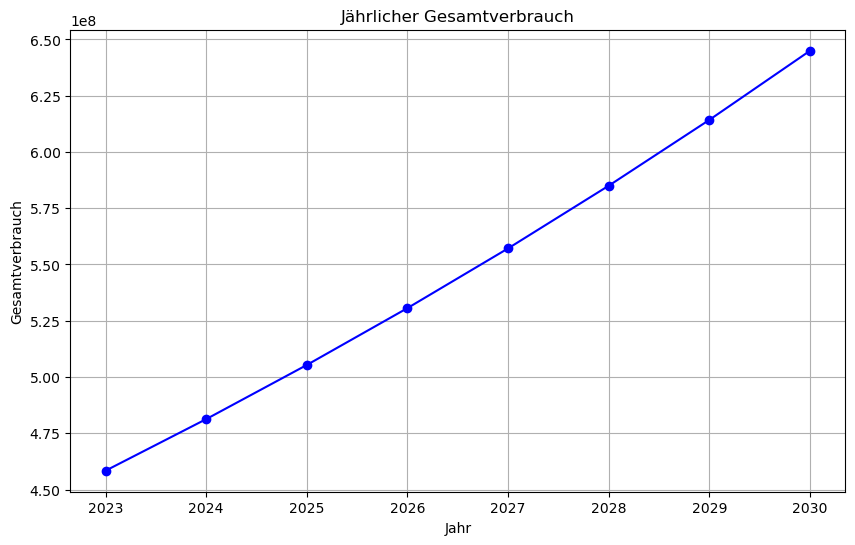

In [226]:
# Gruppieren nach Jahr und Berechnen der Summe der Spalte 'gesamtverbrauch'
yearly_totals = consumption_extrapolation.groupby('Year')['Gesamtverbrauch'].sum()
#print(consumption_extrapolation.columns)

# Umwandeln der Ergebnisse in ein Array
yearly_totals_array = yearly_totals.values

print(yearly_totals_array)

# Erstellen des Liniendiagramms
plt.figure(figsize=(10, 6))
plt.plot(yearly_totals.index, yearly_totals.values, marker='o', linestyle='-', color='b')

# Achsenbeschriftungen und Titel hinzufügen
plt.xlabel('Jahr')
plt.ylabel('Gesamtverbrauch')
plt.title('Jährlicher Gesamtverbrauch')
plt.grid(True)

# Diagramm anzeigen
plt.show()

In [227]:
#print(consumption_extrapolation)
consumption_2030 = directory_yearly_consumption[2030]
print(consumption_2030)

                    Datum  Gesamtverbrauch  Residuallast  Pumpspeicher  Year
0     2030-01-01 00:00:00     13610.882388       1842.50        482.00  2030
1     2030-01-01 00:15:00     13499.017905       1691.50        469.25  2030
2     2030-01-01 00:30:00     13454.694241       1442.50        546.25  2030
3     2030-01-01 00:45:00     13392.078273       1598.50        525.50  2030
4     2030-01-01 01:00:00     13273.530062       1325.50        192.75  2030
...                   ...              ...           ...           ...   ...
35035 2030-12-31 22:45:00     15169.597882       1706.75        373.50  2030
35036 2030-12-31 23:00:00     15129.495520       1701.00        426.50  2030
35037 2030-12-31 23:15:00     14923.003532       1610.25        476.75  2030
35038 2030-12-31 23:30:00     14766.463610       1470.25        468.25  2030
35039 2030-12-31 23:45:00     14476.249148       1338.00        540.75  2030

[35040 rows x 5 columns]
